# Long notebook

Team Name: [054] K-means Krew

Members:
- Sindre Grodås Standal Aas, 543957
- Elias Lerheim Birkeland, 507705
- Daniel Andreas Haugeland, 527829

# General Exploratory Data Analysis

We assume that the data subfolder is located in the same folder as this notebook

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
targets_a = pd.read_parquet('data/A/train_targets.parquet')
targets_b = pd.read_parquet('data/B/train_targets.parquet')
targets_c = pd.read_parquet('data/C/train_targets.parquet')
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index("time")
targets_c = targets_c.set_index("time")


In [26]:
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [27]:
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [28]:
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


- Plotting
- Corr
- Pairs: direct_rad, cloud_to_rad

* Search domain knowledge
2
* Check if the data is intuitive
* Understand how the data was generated * Explore individual features
* Explore pairs and groups of features
* Clean up features

#### Plotting the target datasets

The first thing to note is the difference of magnitude between location a compared to b and c. It is also important to note the amount of missing values from b and c. Location a has less missing values, but no values from early 2019. The plot shows clear seasonal dependencies.

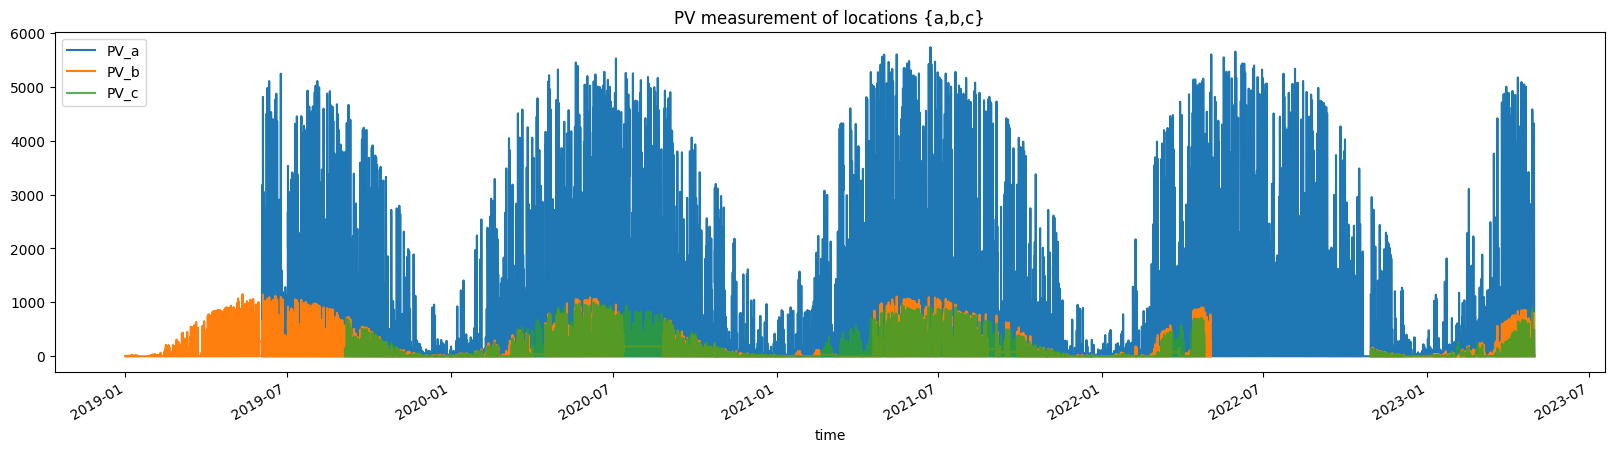

In [29]:
targets_a['pv_measurement'].plot(figsize=(20,5), alpha=1, label='PV_a')
targets_b['pv_measurement'].plot(figsize=(20,5), alpha=1, label='PV_b')
targets_c['pv_measurement'].plot(figsize=(20,5), alpha=.8, label='PV_c')

plt.title('PV measurement of locations {a,b,c}')
plt.legend()
plt.show()

#### Plot the weather features (only location a to save space)

We can see that some features are categorical (e.g.'is_day:idx' and 'is_in_shadow:idx), some features are constant (e.g. 'elevation:m'), while the rest are numerical features. Amongst the features, some are very predictible with respect to time (e.g 'sun_elevation:d and 'clear_sky_energy_1h:J'). The distribution seems to be quite similar between obseved and estimated weather. The plots show clear seasonal dependencies in the freatures.

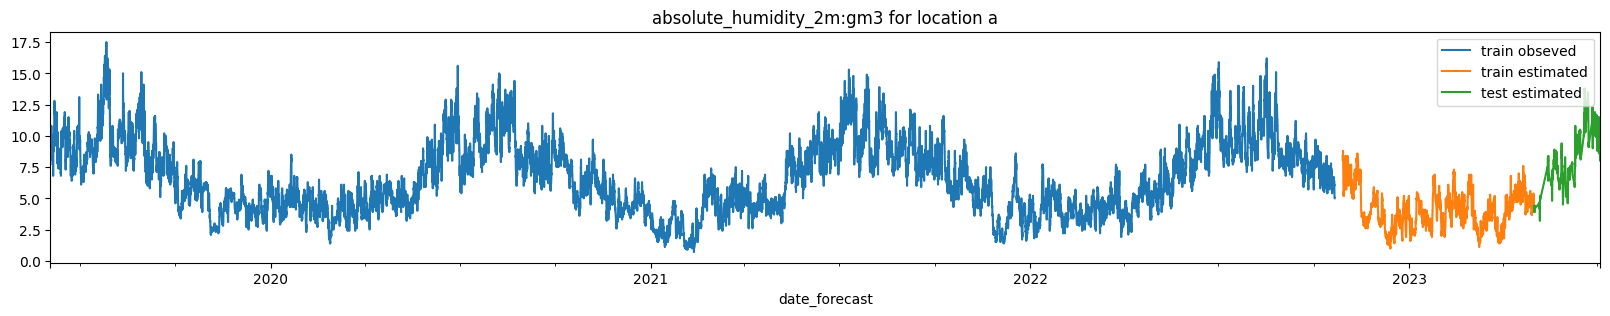

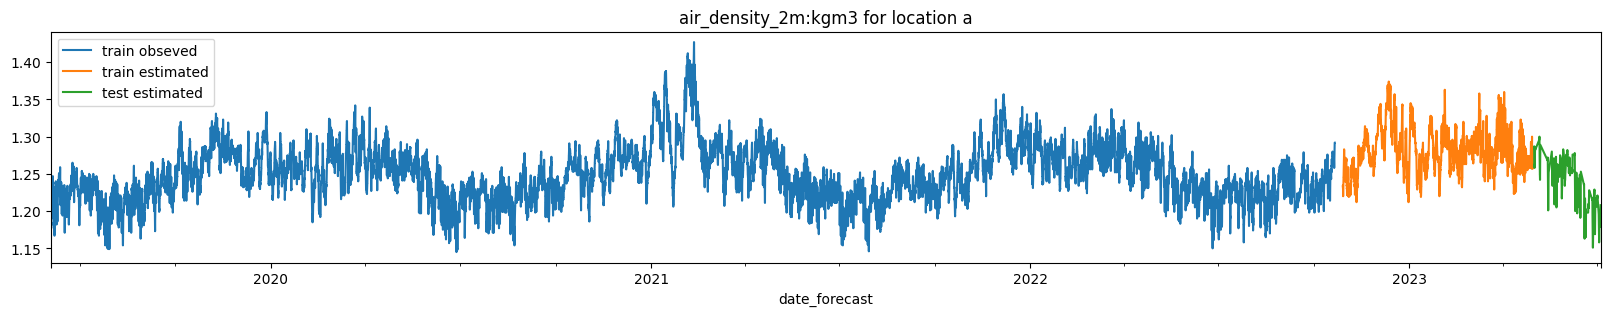

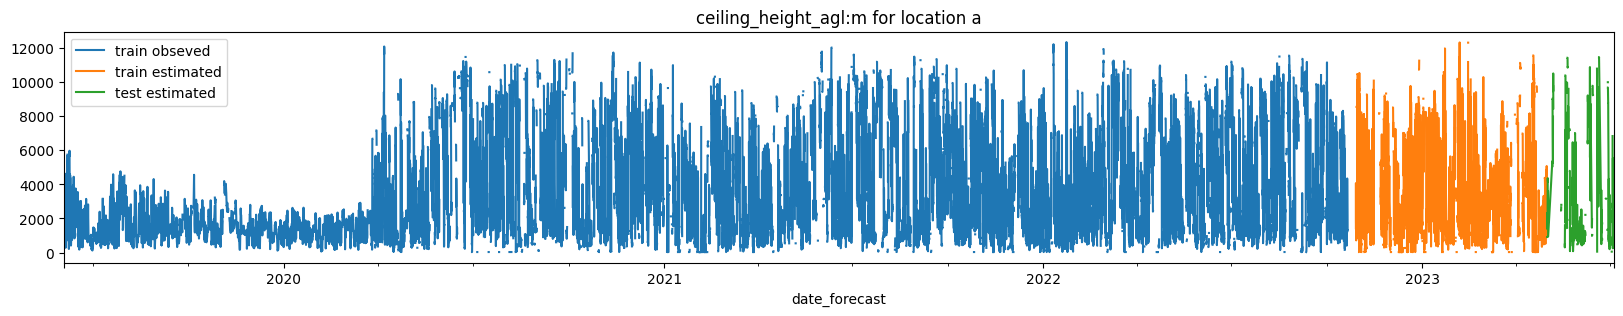

In [75]:
for f in X_train_observed_a.columns:
    X_train_observed_a[f].plot(figsize=(20,3), alpha=1, label="train obseved")

    X_train_estimated_a[f].plot(figsize=(20,3), alpha=1, label="train estimated")

    X_test_estimated_a[f].plot(figsize=(20,3), alpha=1, label="test estimated")


    plt.title(f"{f} for location a")
    plt.legend()
    plt.show()
    

### Plotting important feature pairs

From domain research it is evident that photovoltaic output is higly dependent on sun radiation. Below we have plotted 'direct_rad:W' along with the photovoltaic output. We can see a clear correlation between the two. We have also plotted the 'is_day:idx' feature to show the fact that there are almost no photovoltaic output when the sun is under the horizon.

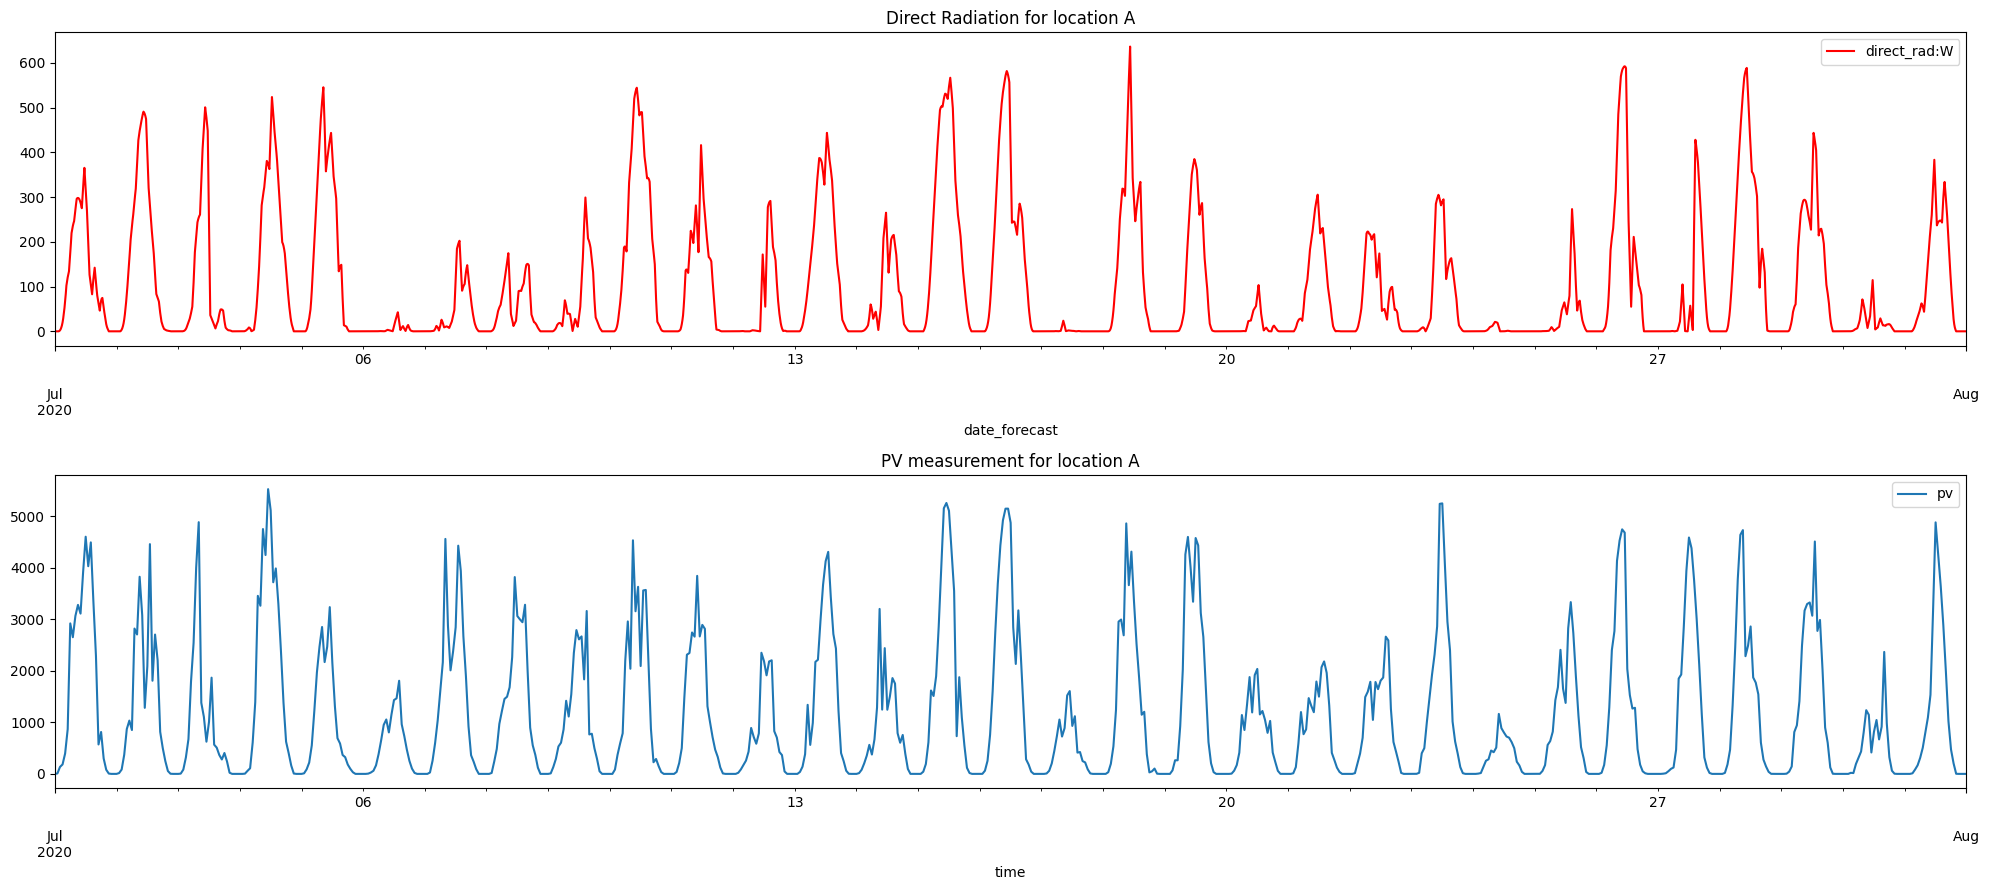

In [ ]:
# Define the datetime interval
start_date = pd.to_datetime('2020-07-01')  # replace with your start date
end_date = pd.to_datetime('2020-08-01')    # replace with your end date

# Setting up the figure and subplots
plt.figure(figsize=(20, 9))


plt.subplot(2, 1, 1)  
X_train_observed_a['direct_rad:W'].loc[start_date:end_date].plot(alpha=1, label="direct_rad:W", color='red')
plt.legend()
plt.title("Direct Radiation for location A")


plt.subplot(2, 1, 2) 
targets_a['pv_measurement'].loc[start_date:end_date].plot(alpha=1, label="pv")
plt.legend()
plt.title("PV measurement for location A")



# Display the plots
plt.tight_layout()  
plt.show()


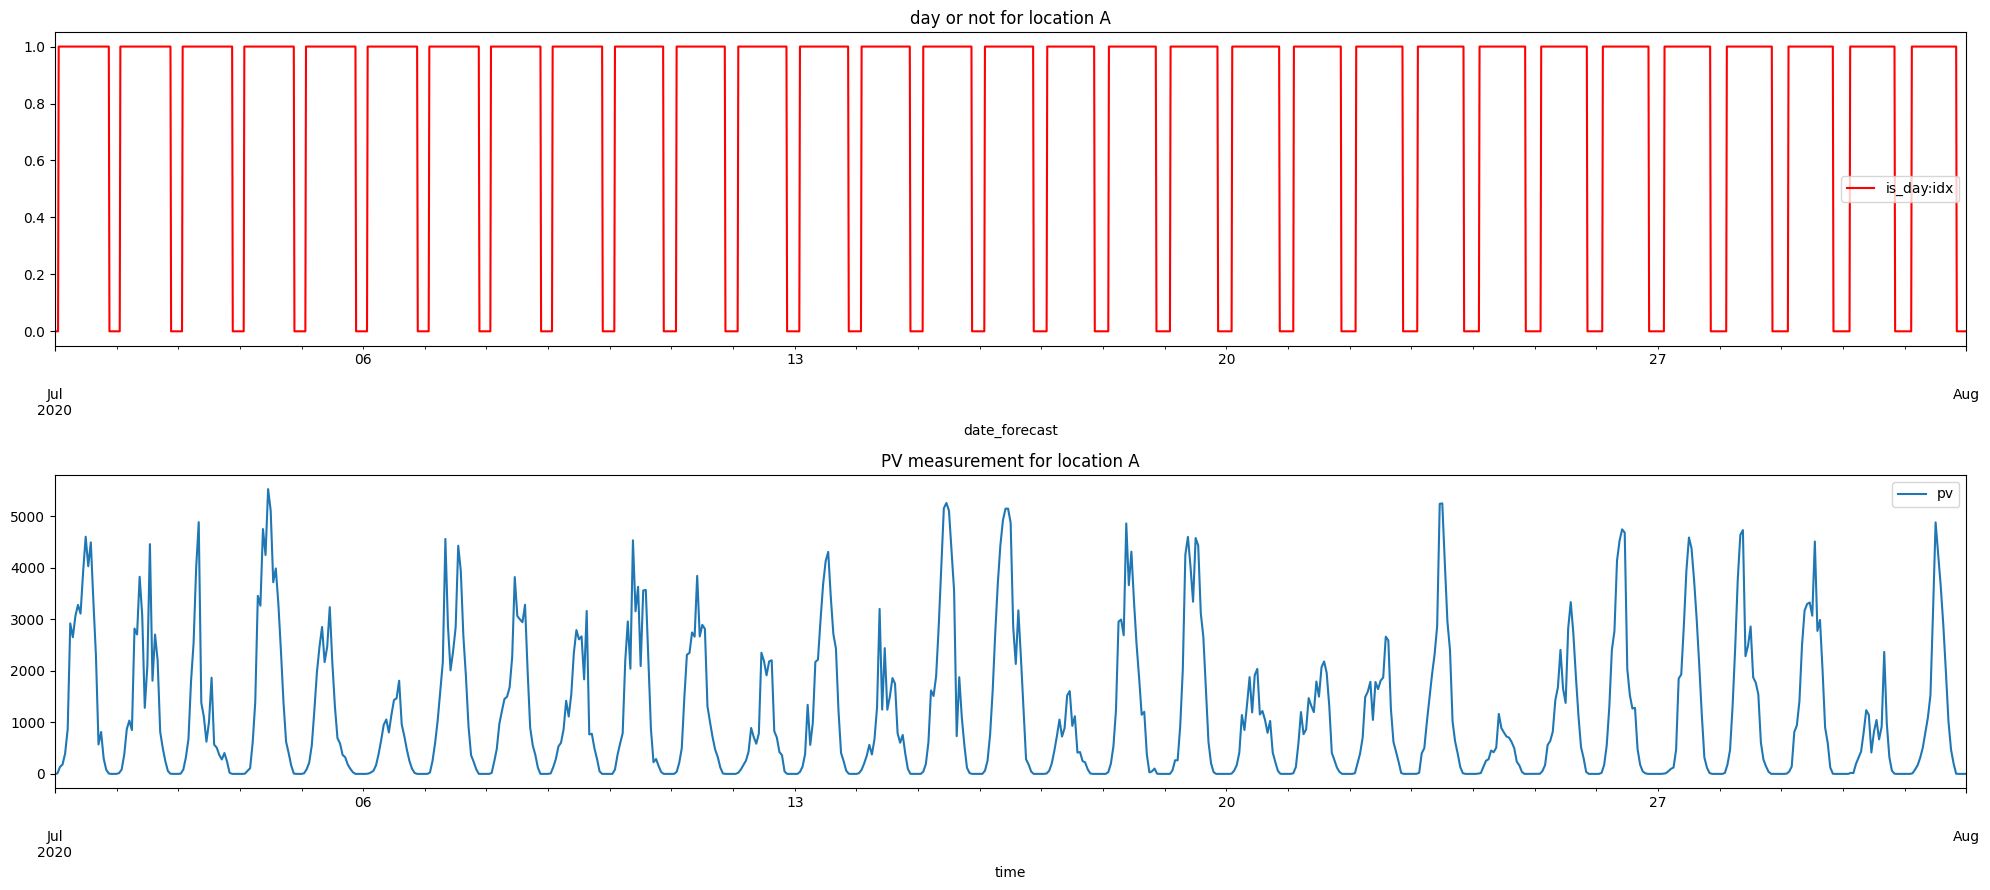

In [ ]:
# Define the datetime interval
start_date = pd.to_datetime('2020-07-01')  # replace with your start date
end_date = pd.to_datetime('2020-08-01')    # replace with your end date

# Setting up the figure and subplots
plt.figure(figsize=(20, 9))


plt.subplot(2, 1, 1)  
X_train_observed_a['is_day:idx'].loc[start_date:end_date].plot(alpha=1, label="is_day:idx", color='red')
plt.legend()
plt.title("day or not for location A")


plt.subplot(2, 1, 2) 
targets_a['pv_measurement'].loc[start_date:end_date].plot(alpha=1, label="pv")
plt.legend()
plt.title("PV measurement for location A")



# Display the plots
plt.tight_layout()  
plt.show()

### Feature Relationships

By plotting a correlation matrix, we can see that some features are very dependent, e.g. 'sun_elevation' and 'clear_sky_energy_1h:J'. When plotting the correlation between the features and 'pv_measurement, we can see that the radiation features are most correlatied. This makes sense with our domain knowledge of photovoltaic cells. It is quite intuitive that the features related to the sun – or lack of sun – are quite important.

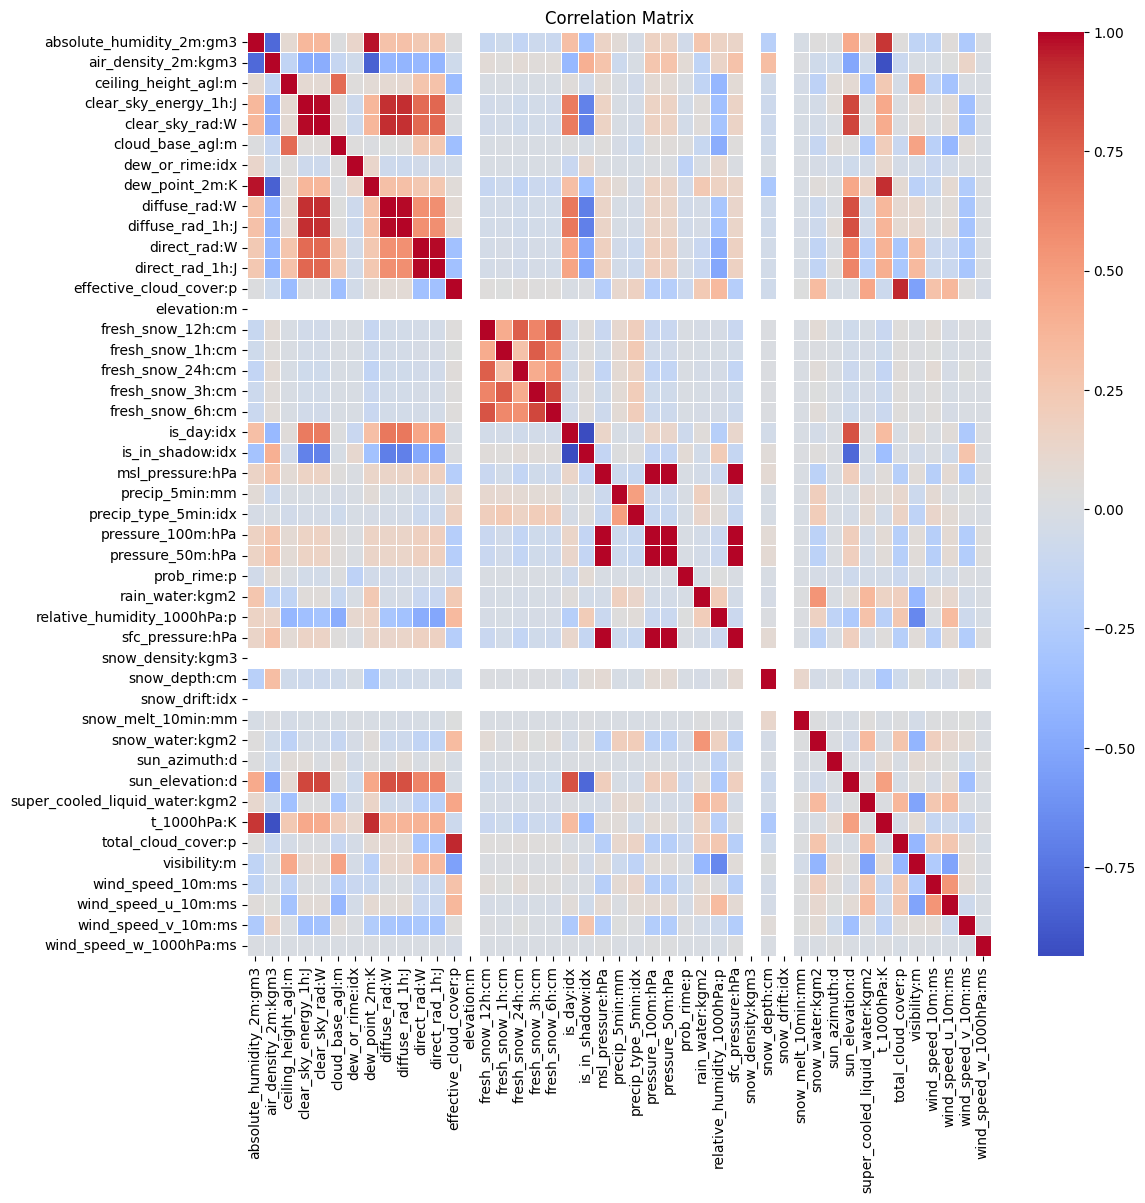

In [ ]:
corr_matrix = X_train_observed_a.corr()

# Create a heatmap to visualize the correlation matrix without annotations
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_10156\543410509.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=correlation_with_target, y='Feature', x='Correlation', palette='coolwarm')


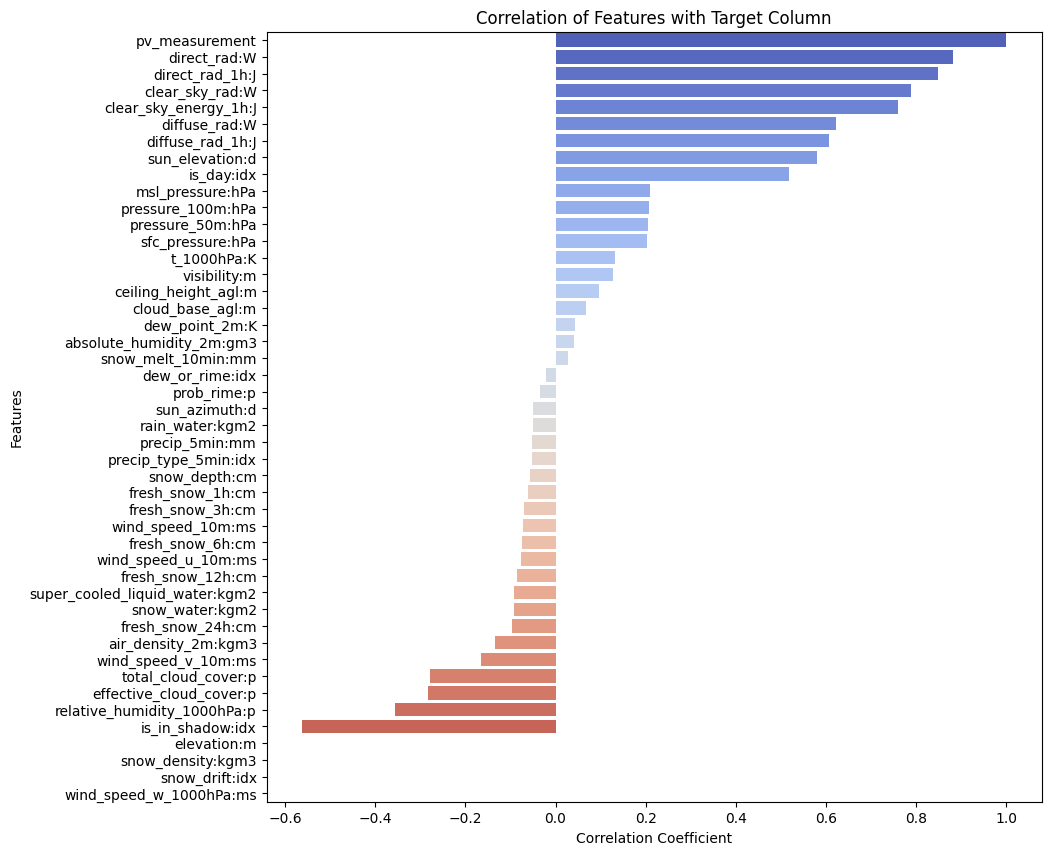

In [ ]:
combined_df = X_train_estimated_a.merge(targets_a, left_index=True, right_index=True)


# Calculate correlation with the target column
correlation_with_target = combined_df.corrwith(combined_df['pv_measurement'], numeric_only=True)

# Convert to DataFrame for easy plotting
correlation_with_target = correlation_with_target.sort_values(ascending=False).to_frame().reset_index()
correlation_with_target.columns = ['Feature', 'Correlation']

# Plotting
plt.figure(figsize=(10, 10))  # Adjust the figure size as necessary
sns.barplot(data=correlation_with_target, y='Feature', x='Correlation', palette='coolwarm')
plt.title('Correlation of Features with Target Column')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


### Helper functions

In [ ]:
def plot_ts(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots all the y arrays, then all the x arrays.
    """
    fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
    i = 0
    for df in y:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean().plot(ax=axs[i])
        i += 1
    
    for df in x:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
        axs[i].legend()
        i += 1
    
            
def plot_ts1(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots the y and x values directly under each other for each location
    """
    
    if len(x) != len(y):
        print("Error: arrays 'y' and 'x' are different lengths. Please provide equal sized arrays.")
    else:
        fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
        i = 0
        for df_y, df_x in zip(y, x):
                df_y[(df_y.index >= start) & (df_y.index <= end)].resample("H").mean().plot(ax=axs[i])
                i += 1
                df_x[(df_x.index >= start) & (df_x.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
                axs[i].legend()
                i += 1
  

def remove_constant_values(df, column_name, threshold):
    
    new_df = df.copy()

    # Find the consecutive constant rows
    consecutive_constants = new_df.groupby((new_df[column_name] != new_df[column_name].shift()).cumsum()).filter(lambda x: len(x) > threshold)

    # Filter out the consecutive constant rows from the original DataFrame
    filtered_df = new_df[~new_df.index.isin(consecutive_constants.index)]
    
    return filtered_df


## Check If The Data is Intuitive

When plotting the data we noticed that there are constant pv_measurements that are not 0, which seems faulty.

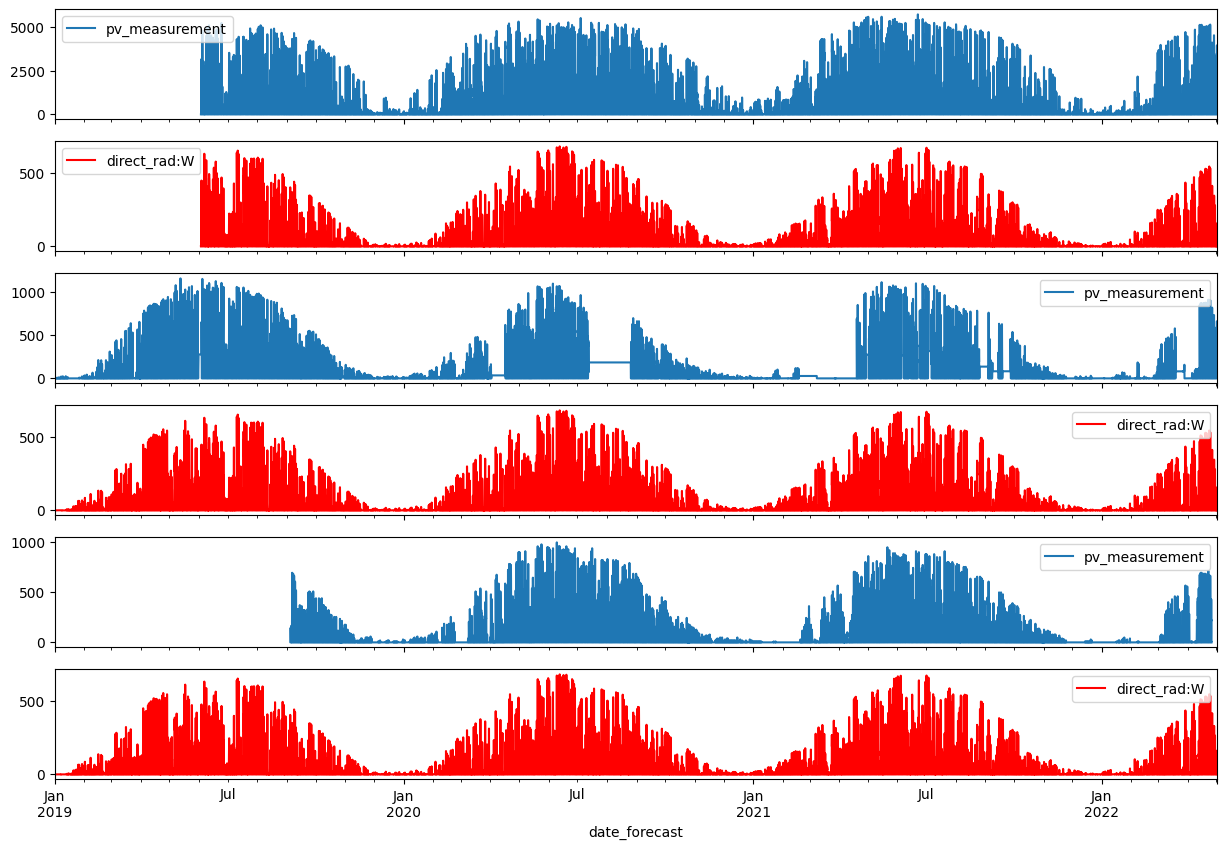

In [ ]:
### generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad:W"

Y = [targets_a, targets_b, targets_c,]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c,]

plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

We use a function to remove these values, and see the changes from the plot. We set the threshold to 18 hours, as that is roughly the length of the longest night of the year (we do not want to remove the nightime where pv_measurement should be 0.)

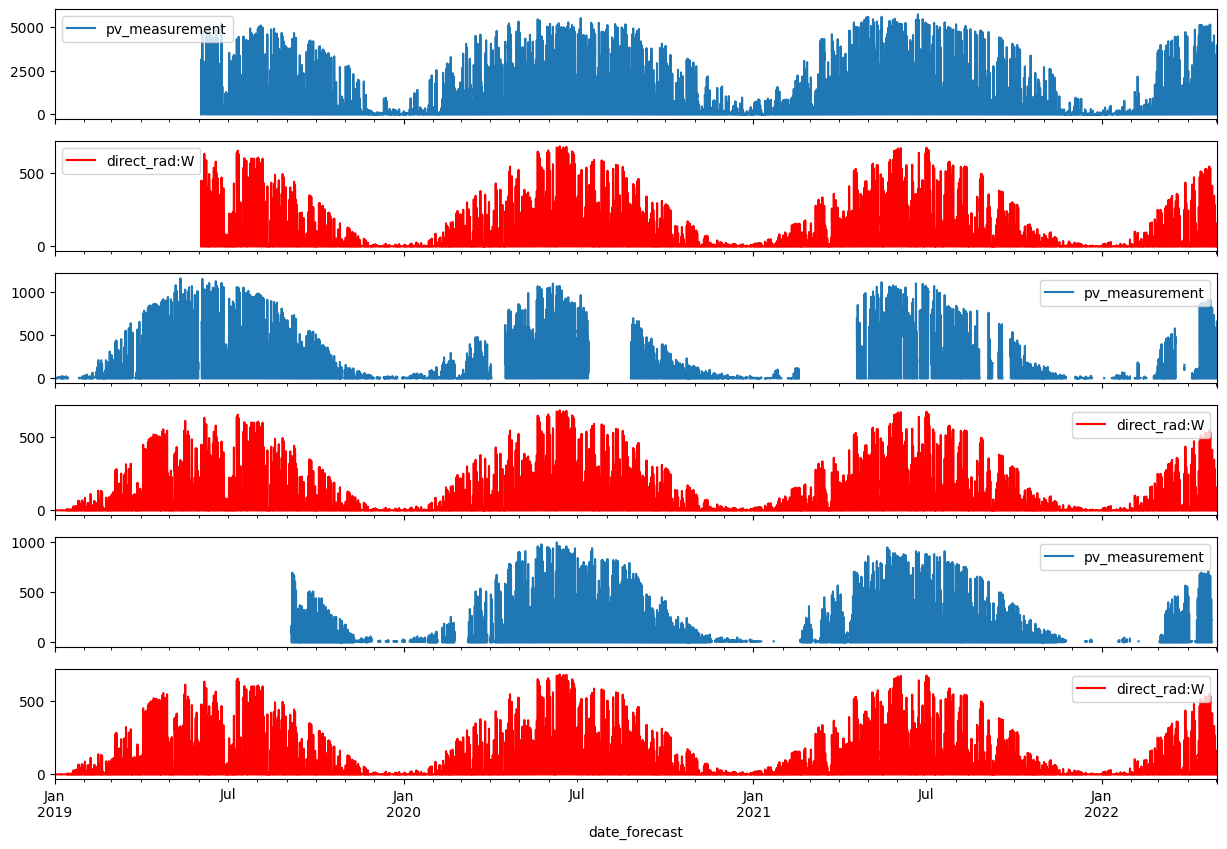

In [ ]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_a = remove_constant_values(targets_a, "pv_measurement", 18).dropna()
targets_b = remove_constant_values(targets_b, "pv_measurement", 18).dropna()
targets_c = remove_constant_values(targets_c, "pv_measurement", 18).dropna()

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

start_date = '2019'
end_date = '2024'
feature_name = "direct_rad:W"

plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

## Clean Up Features

We checked if some features had missing values. For example in all of our attempts with the AutoGluon model, we remove the snow_density column. Although not printed here, we have checked the train_estimated and test_estimated datasets as well.

In [ ]:
print(X_train_observed_a.shape[0])
print(X_train_observed_a.columns.shape[0])
X_train_observed_a.isna().sum()

118669
45


absolute_humidity_2m:gm3               0
air_density_2m:kgm3                    0
ceiling_height_agl:m               22247
clear_sky_energy_1h:J                  0
clear_sky_rad:W                        0
cloud_base_agl:m                    8066
dew_or_rime:idx                        0
dew_point_2m:K                         0
diffuse_rad:W                          0
diffuse_rad_1h:J                       0
direct_rad:W                           0
direct_rad_1h:J                        0
effective_cloud_cover:p                0
elevation:m                            0
fresh_snow_12h:cm                      0
fresh_snow_1h:cm                       0
fresh_snow_24h:cm                      0
fresh_snow_3h:cm                       0
fresh_snow_6h:cm                       0
is_day:idx                             0
is_in_shadow:idx                       0
msl_pressure:hPa                       0
precip_5min:mm                         0
precip_type_5min:idx                   0
pressure_100m:hP

In [ ]:
print(X_train_observed_b.shape[0])
print(X_train_observed_b.columns.shape[0])
X_train_observed_b.isna().sum()

116929
45


absolute_humidity_2m:gm3               0
air_density_2m:kgm3                    0
ceiling_height_agl:m               18772
clear_sky_energy_1h:J                  0
clear_sky_rad:W                        0
cloud_base_agl:m                    7473
dew_or_rime:idx                        0
dew_point_2m:K                         0
diffuse_rad:W                          0
diffuse_rad_1h:J                       0
direct_rad:W                           0
direct_rad_1h:J                        0
effective_cloud_cover:p                0
elevation:m                            0
fresh_snow_12h:cm                      0
fresh_snow_1h:cm                       0
fresh_snow_24h:cm                      0
fresh_snow_3h:cm                       0
fresh_snow_6h:cm                       0
is_day:idx                             0
is_in_shadow:idx                       0
msl_pressure:hPa                       0
precip_5min:mm                         0
precip_type_5min:idx                   0
pressure_100m:hP

In [ ]:
print(X_train_observed_c.shape[0])
print(X_train_observed_c.columns.shape[0])
X_train_observed_c.isna().sum()

116825
45


absolute_humidity_2m:gm3               0
air_density_2m:kgm3                    0
ceiling_height_agl:m               19923
clear_sky_energy_1h:J                  0
clear_sky_rad:W                        0
cloud_base_agl:m                    8512
dew_or_rime:idx                        0
dew_point_2m:K                         0
diffuse_rad:W                          0
diffuse_rad_1h:J                       0
direct_rad:W                           0
direct_rad_1h:J                        0
effective_cloud_cover:p                0
elevation:m                            0
fresh_snow_12h:cm                      0
fresh_snow_1h:cm                       0
fresh_snow_24h:cm                      0
fresh_snow_3h:cm                       0
fresh_snow_6h:cm                       0
is_day:idx                             0
is_in_shadow:idx                       0
msl_pressure:hPa                       0
precip_5min:mm                         0
precip_type_5min:idx                   0
pressure_100m:hP

# Predictors:

# XGBoost

One of our earlier attempts utilized the XGBoost algorithm. The preprocessing we did was removing targets (pv_measurement), where the value remained constant for over 18 hours. We assumed this to be an error in the measurements. As the targets variables are on an hourly interval and the weather features are each quarter hour - we simply merged the X and y dataframes on every whole hour. For feature engineering we created some time based features such as hour, dayofyear, month etc. We tried running the model with different validation data and removing various features based on low importance. Ultimately the best result we got with this model was 154.768849 on Kaggle. This version simply used all the 45 weather features on each location. And only trained on actual observed weather. Regarding model interpretation we looked at the feature importances for each location, in addition to using the X_train_estimated weather as a local test set. We looked at the plots for the model predictions vs the plots of the actual pv_measurements. We also printed the largest errors the model made to try to interpret what went wrong.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


### Reading in files and indexing them on time

In [ ]:
targets_a = pd.read_parquet('data/A/train_targets.parquet')
targets_b = pd.read_parquet('data/B/train_targets.parquet')
targets_c = pd.read_parquet('data/C/train_targets.parquet')
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index("time")
targets_c = targets_c.set_index("time")


In [ ]:
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [ ]:
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [ ]:
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


### Helper functions

In [ ]:
def plot_ts(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots all the y arrays, then all the x arrays.
    """
    fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
    i = 0
    for df in y:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean().plot(ax=axs[i])
        i += 1
    
    for df in x:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
        axs[i].legend()
        i += 1
    
            
def plot_ts1(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots the y and x values directly under each other for each location
    """
    
    if len(x) != len(y):
        print("Error: arrays 'y' and 'x' are different lengths. Please provide equal sized arrays.")
    else:
        fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
        i = 0
        for df_y, df_x in zip(y, x):
                df_y[(df_y.index >= start) & (df_y.index <= end)].resample("H").mean().plot(ax=axs[i])
                i += 1
                df_x[(df_x.index >= start) & (df_x.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
                axs[i].legend()
                i += 1
  

def remove_constant_values(df, column_name, threshold):
    
    new_df = df.copy()

    # Find the consecutive constant rows
    consecutive_constants = new_df.groupby((new_df[column_name] != new_df[column_name].shift()).cumsum()).filter(lambda x: len(x) > threshold)

    # Filter out the consecutive constant rows from the original DataFrame
    filtered_df = new_df[~new_df.index.isin(consecutive_constants.index)]
    
    return filtered_df


### Model Specific EDA

In [ ]:
# Notice that missing rows are simply non-existent for Y_train_a, not filled with NaN or anything
# From 21. october
display(targets_a[29660:29670])

,pv_measurement
time,
2022-10-20 18:00:00,0.0
2022-10-20 19:00:00,0.0
2022-10-20 20:00:00,0.0
2022-10-20 21:00:00,0.0
2022-10-20 22:00:00,0.0
2022-10-20 23:00:00,0.0
2022-10-21 00:00:00,0.0
2022-10-28 22:00:00,0.0
2022-10-28 23:00:00,0.0


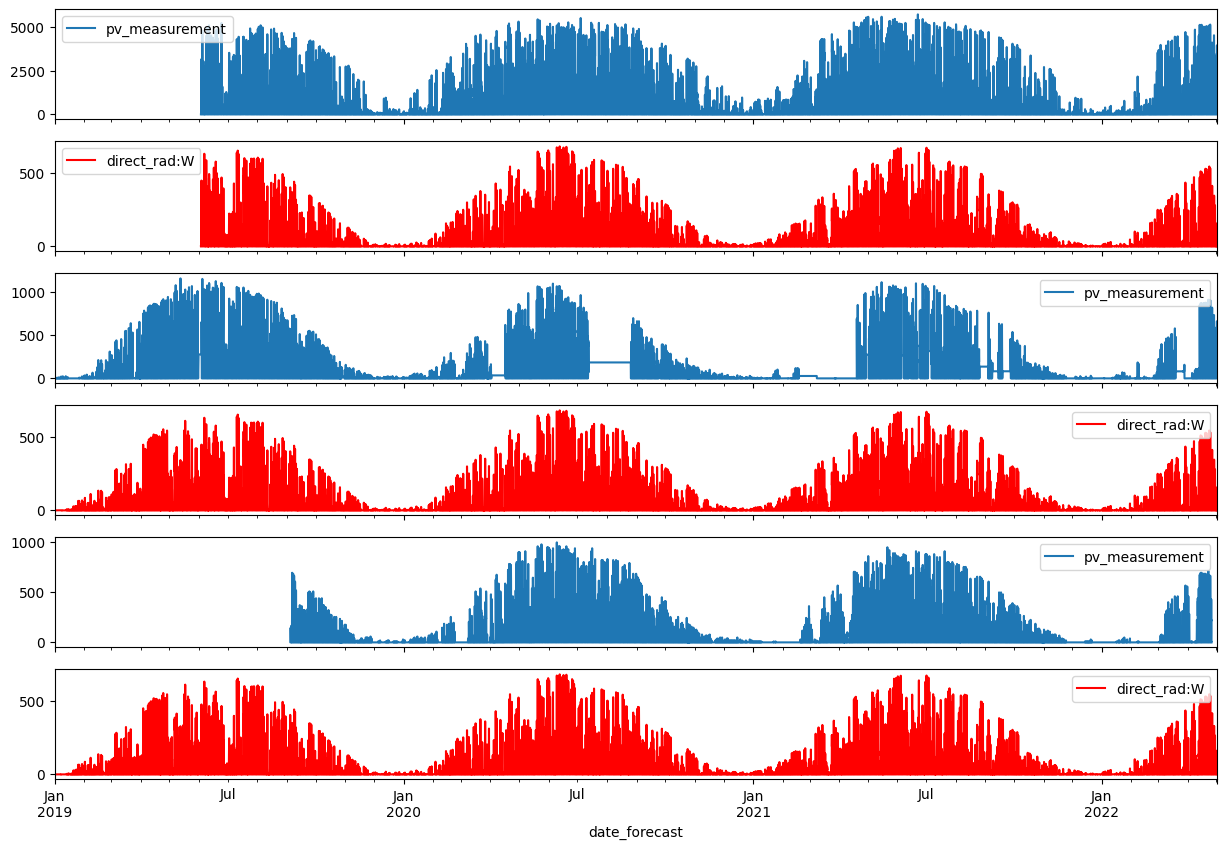

In [ ]:
### generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad:W"

Y = [targets_a, targets_b, targets_c,]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c,]

plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

### Preprocessing and Feature Engineering 

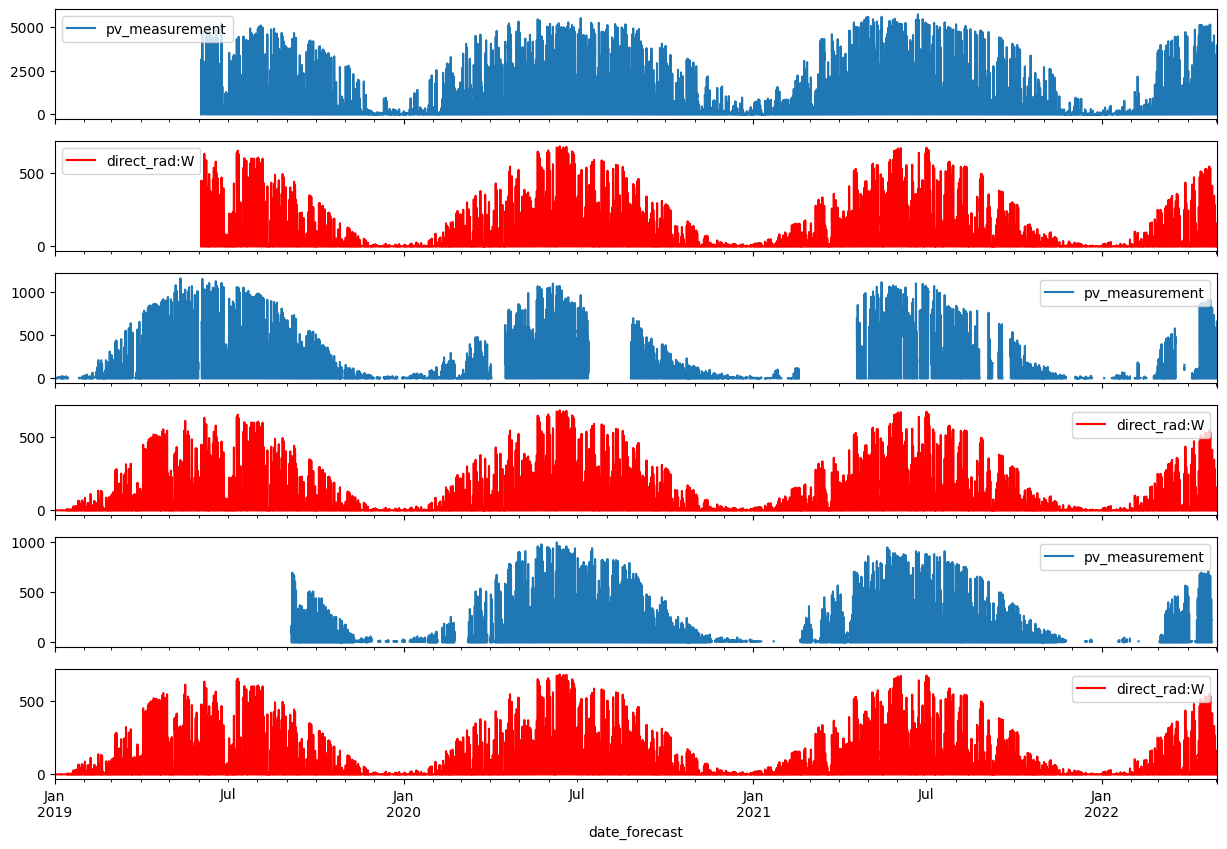

In [ ]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_a = remove_constant_values(targets_a, "pv_measurement", 18).dropna()
targets_b = remove_constant_values(targets_b, "pv_measurement", 18).dropna()
targets_c = remove_constant_values(targets_c, "pv_measurement", 18).dropna()

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

start_date = '2019'
end_date = '2024'
feature_name = "direct_rad:W"

plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

In [ ]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['quarter'] = new_df.index.quarter
    new_df['month'] = new_df.index.month
    new_df['year'] = new_df.index.year
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['dayofmonth'] = new_df.index.day
    # new_df['weekofyear'] = new_df.index.isocalendar().week
    return new_df

In [ ]:
### Adding more time based features to the datasets
X_train_observed_a = create_features(X_train_observed_a)
X_train_observed_b = create_features(X_train_observed_b)
X_train_observed_c = create_features(X_train_observed_c)

X_train_estimated_a = create_features(X_train_estimated_a)
X_train_estimated_b = create_features(X_train_estimated_b)
X_train_estimated_c = create_features(X_train_estimated_c)

X_test_estimated_a = create_features(X_test_estimated_a)
X_test_estimated_b = create_features(X_test_estimated_b)
X_test_estimated_c = create_features(X_test_estimated_c)

In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)

In [ ]:
# # Check which features most correlated with y
# correlations = train_a.corrwith(train_a["pv_measurement"])
# for index, corr in correlations.items():
#     correlations[index] = abs(corr)

# sorted = correlations.sort_values(ascending=False)
# best_features = list(sorted[1:10].index)
# print(best_features)

### Creating The Model

#### Select Features

In [ ]:
# Step 1: Create the full list of features
FEATURES = list(train_a.columns[:-1])  # Using all the features of X.
TARGETS = "pv_measurement"

### DATA
X_a = train_a[FEATURES]
y_a = train_a[TARGETS]

X_b = train_b[FEATURES]
y_b = train_b[TARGETS]

X_c = train_c[FEATURES]
y_c = train_c[TARGETS]

#### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters and their possible values
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [100, 200, 500, 1000],
    'gamma': [0, 0.25, 0.5, 1.0],
    'min_child_weight': [1, 2, 3, 4]
}

# Initialize XGBRegressor
reg = xgb.XGBRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    reg, 
    param_distributions=param_dist, 
    n_iter=100, 
    scoring='neg_mean_absolute_error', 
    verbose=1, 
    cv=3, 
    n_jobs=-1
)

# Fit the model
# random_search.fit(X_train_a, y_train_a)
# random_search.fit(X_train_b, y_train_b)
# random_search.fit(X_train_c, y_train_c)

# Print the best parameters
# print(random_search.best_params_)


In [ ]:
default_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'early_stopping_rounds': 100,
    'objective': 'reg:absoluteerror'
}

best_params_a = {'subsample': 0.9, 
               'n_estimators': 1000, 
               'min_child_weight': 3, 
               'max_depth': 8, 
               'learning_rate': 0.05, 
               'gamma': 0.25, 
               'colsample_bytree': 0.5,
               'objective': 'reg:absoluteerror',
               'early_stopping_rounds': 10}

best_params_bc = {'subsample': 0.7, 
                  'n_estimators': 1000,
                  'min_child_weight': 3, 
                  'max_depth': 7, 
                  'learning_rate': 0.05, 
                  'gamma': 0.5, 
                  'colsample_bytree': 0.5,
                  'objective': 'reg:absoluteerror',
                  'early_stopping_rounds': 10}

#### Train/Test split

In [ ]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

#### Location A

In [ ]:
### Location A

# Create an XGBoostRegressor with some default hyperparameters
reg_A = xgb.XGBRegressor(**best_params_a)

# Fit the model on the training data
reg_A.fit(X_train_a, y_train_a,
        eval_set = [(X_train_a, y_train_a), (X_test_a, y_test_a)],
        verbose=100)

# Make predictions on the test data
y_pred_a = reg_A.predict(X_test_a)

y_pred_a = np.clip(y_pred_a, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_a, y_pred_a)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:690.68542	validation_1-mae:693.86945


[100]	validation_0-mae:183.22787	validation_1-mae:210.68898
[200]	validation_0-mae:173.75083	validation_1-mae:207.17140
[284]	validation_0-mae:168.54746	validation_1-mae:205.95939
Mean Absolute Error: 205.849753767182


#### Location B

In [ ]:
### Location B

# Create an XGBoostRegressor with some default hyperparameters
reg_B = xgb.XGBRegressor(**best_params_bc)

# Fit the model on the training data
reg_B.fit(X_train_b, y_train_b,
        eval_set = [(X_train_b, y_train_b), (X_test_b, y_test_b)],
        verbose=100)

# Make predictions on the test data
y_pred_b = reg_B.predict(X_test_b)

y_pred_b = np.clip(y_pred_b, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_b, y_pred_b)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:131.92966	validation_1-mae:129.91867
[100]	validation_0-mae:30.08613	validation_1-mae:35.09871
[200]	validation_0-mae:27.71280	validation_1-mae:33.75253
[300]	validation_0-mae:26.62202	validation_1-mae:33.44821
[400]	validation_0-mae:25.67398	validation_1-mae:33.14984
[437]	validation_0-mae:25.24789	validation_1-mae:33.09011
Mean Absolute Error: 33.039399620108036


#### Location C

In [ ]:
### Location C

# Create an XGBoostRegressor with some default hyperparameters
reg_C = xgb.XGBRegressor(**best_params_bc)

# Fit the model on the training data
reg_C.fit(X_train_c, y_train_c,
        eval_set = [(X_train_c, y_train_c), (X_test_c, y_test_c)],
        verbose=100)

# Make predictions on the test data
y_pred_c = reg_C.predict(X_test_c)

y_pred_c = np.clip(y_pred_c, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_c, y_pred_c)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:113.80080	validation_1-mae:107.99255
[100]	validation_0-mae:25.35180	validation_1-mae:29.80970
[200]	validation_0-mae:23.26184	validation_1-mae:29.00731
[300]	validation_0-mae:21.92259	validation_1-mae:28.64285
[400]	validation_0-mae:21.18741	validation_1-mae:28.44089
[416]	validation_0-mae:21.06098	validation_1-mae:28.44120
Mean Absolute Error: 28.389031612816215


### Model Interpretation

#### Feature Importance

In [ ]:
fi_a = pd.DataFrame(data=reg_A.feature_importances_,
             index=reg_A.feature_names_in_,
             columns=["importance"])
fi_a.sort_values("importance", ascending=False).head(100)

,importance
is_in_shadow:idx,0.489717
is_day:idx,0.252925
diffuse_rad:W,0.074727
sun_elevation:d,0.052395
clear_sky_rad:W,0.022581
diffuse_rad_1h:J,0.017616
clear_sky_energy_1h:J,0.015403
hour,0.010286
direct_rad:W,0.006587
sun_azimuth:d,0.004729


In [ ]:
fi_b = pd.DataFrame(data=reg_B.feature_importances_,
             index=reg_B.feature_names_in_,
             columns=["importance"])
fi_b.sort_values("importance", ascending=False).head()

,importance
is_in_shadow:idx,0.443812
is_day:idx,0.203897
sun_elevation:d,0.064543
diffuse_rad:W,0.062640
clear_sky_rad:W,0.050568


In [ ]:
fi_c = pd.DataFrame(data=reg_C.feature_importances_,
             index=reg_C.feature_names_in_,
             columns=["importance"])
fi_c.sort_values("importance", ascending=False).head()

,importance
is_day:idx,0.290992
is_in_shadow:idx,0.243845
sun_elevation:d,0.104053
diffuse_rad:W,0.078449
clear_sky_rad:W,0.056644


#### Visualizing the validation sets

<Axes: >

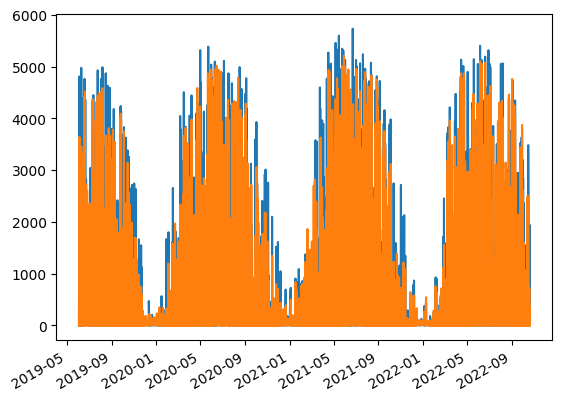

In [ ]:
y_test_a.plot()
X_test_a["prediction"] = y_pred_a
X_test_a["prediction"].plot()

<Axes: >

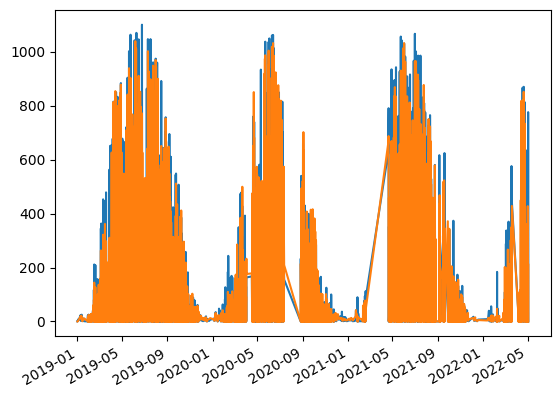

In [ ]:
y_test_b.plot()
X_test_b["prediction"] = y_pred_b
X_test_b["prediction"].plot()

<Axes: >

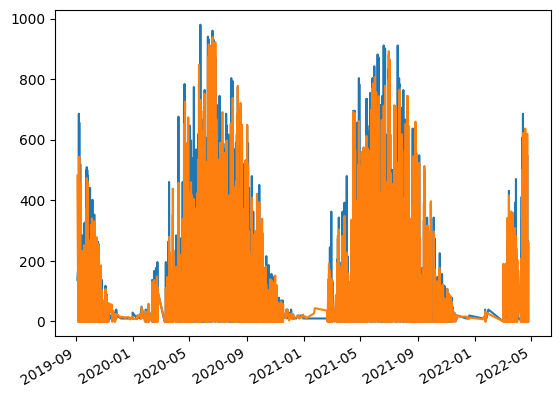

In [ ]:
y_test_c.plot()
X_test_c["prediction"] = y_pred_c
X_test_c["prediction"].plot()

#### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-28 11:00:00    3500.389766
2023-04-28 12:00:00    2992.480371
2023-04-28 10:00:00    2860.264375
2023-03-20 11:00:00    2652.136035
2023-03-23 13:00:00    2522.055693
Name: error, dtype: float64

Mean Absolute Error: 133.20667696002664
MAE for the last 1000 values: 263.47872461428807


<Axes: >

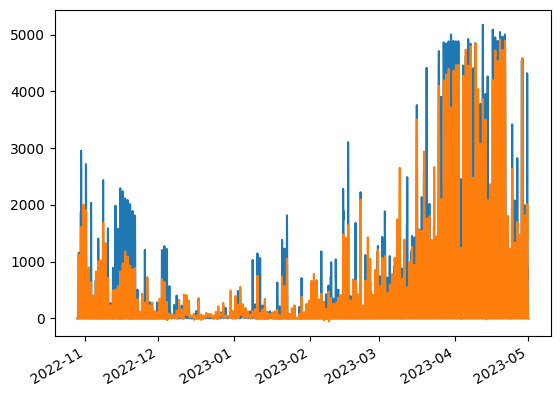

In [ ]:
df = X_train_estimated_a[FEATURES]
df["prediction"] = reg_A.predict(X_train_estimated_a[FEATURES])

df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

2023-04-28 11:00:00    594.524804
2023-04-28 12:00:00    538.453257
2023-04-30 12:00:00    523.711046
2023-04-08 11:00:00    448.011811
2023-04-28 10:00:00    426.759829
Name: error, dtype: float64

Mean Absolute Error: 18.456747721439726
MAE for the last 1000 values: 37.68119691017592


<Axes: >

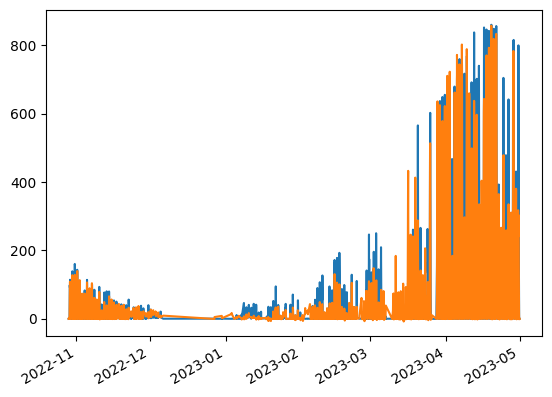

In [ ]:
df = X_train_estimated_b[FEATURES]
df["prediction"] = reg_B.predict(X_train_estimated_b[FEATURES])

df = pd.merge(df, targets_b, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

print(f"Mean Absolute Error: {mae}")

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()

2023-03-27 12:00:00    423.868058
2023-03-27 11:00:00    415.713096
2023-03-19 10:00:00    342.950509
2023-03-27 10:00:00    336.597632
2023-04-14 11:00:00    334.134143
Name: error, dtype: float64

Mean Absolute Error: 26.43018402878973
MAE for the last 1000 values: 47.99353056355397


<Axes: >

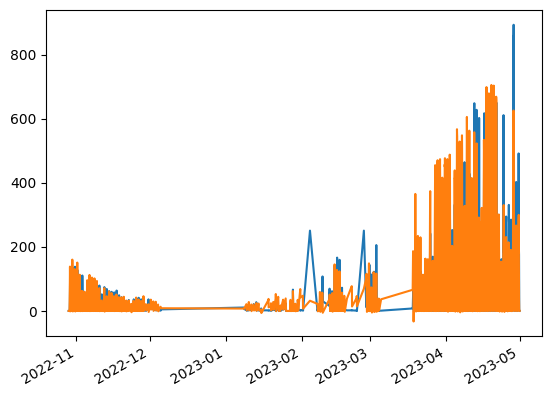

In [ ]:
df = X_train_estimated_c[FEATURES]
df["prediction"] = reg_C.predict(X_train_estimated_c[FEATURES])

df = pd.merge(df, targets_c, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])
print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()


### Predicting On The Actual Kaggle Set

In [ ]:
### Location A
X_test_estimated_a = X_test_estimated_a[FEATURES]
A_pred = reg_A.predict(X_test_estimated_a)
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])
    

In [ ]:
### Location B
X_test_estimated_b = X_test_estimated_b[FEATURES]
B_pred = reg_B.predict(X_test_estimated_b)
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

In [ ]:
   
### Location C
X_test_estimated_c = X_test_estimated_c[FEATURES]
C_pred = reg_C.predict(X_test_estimated_c)
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

#### Visualizing how the model predicts on the actual test set

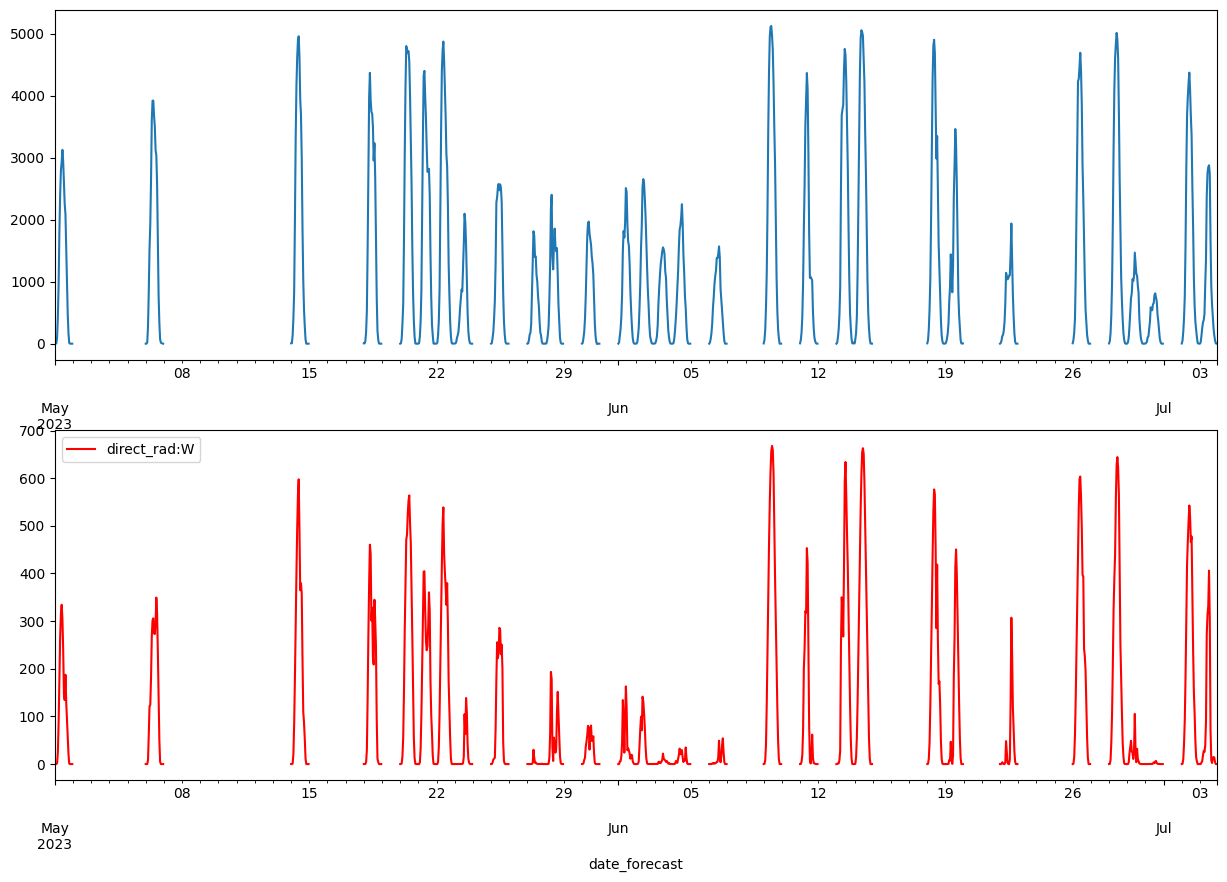

In [ ]:
df = X_test_estimated_a.copy()
df["prediction"] = reg_A.predict(X_test_estimated_a[FEATURES])

start = "05-2023"
end = "08-2023"
feature = "direct_rad:W"

plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)



#### Storing the predictions

In [ ]:
predictions = np.concatenate([A_pred_hourly, B_pred_hourly, C_pred_hourly])
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
df.to_csv("xgboost.csv", index=False)

# AutoGluon

In [ ]:
### Run if AutoGluon not installed
# ! pip install autogluon

The model that gave us the best results was the AutoML model AutoGluon, which combines a bunch of traditional tree-based algorithms, in addition to neural networks and clustering algorithms. We have tried many different combinations of all the things we mentioned under Data Preprocessing, Feature Engineering and Model Training. We will provide a brief overview in text, and also some code for each location.

### Data Preprocessing

Similarly to the XGBoost model, we used some functions to plot different features and the target value up against each other. See "Helper functions." We also used the remove_constant_values() functions to remove rows where the target variable remained constant for different user specified thresholds, while also dropping NaN values.

We also tried normalizing all the X features, but that led to worse results.

#### Helper functions

In [ ]:
def plot_ts(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots all the y arrays, then all the x arrays.
    """
    fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
    i = 0
    for df in y:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean().plot(ax=axs[i])
        i += 1
    
    for df in x:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
        axs[i].legend()
        i += 1
    
            
def plot_ts1(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots the y and x values directly under each other for each location
    """
    
    if len(x) != len(y):
        print("Error: arrays 'y' and 'x' are different lengths. Please provide equal sized arrays.")
    else:
        fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
        i = 0
        for df_y, df_x in zip(y, x):
                df_y[(df_y.index >= start) & (df_y.index <= end)].resample("H").mean().plot(ax=axs[i])
                i += 1
                df_x[(df_x.index >= start) & (df_x.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
                axs[i].legend()
                i += 1
  

def remove_constant_values(df, column_name, threshold):
    
    new_df = df.copy()

    # Find the consecutive constant rows
    consecutive_constants = new_df.groupby((new_df[column_name] != new_df[column_name].shift()).cumsum()).filter(lambda x: len(x) > threshold)

    # Filter out the consecutive constant rows from the original DataFrame
    filtered_df = new_df[~new_df.index.isin(consecutive_constants.index)]
    
    return filtered_df


### Feature Engineering

We have tried the following. Please see the example code for Location A:
- adding time based features such as hour, day, month etc.
- encoding those features as sine and cosine functions.
- taking the mean of the 15 min interval features of each hourly period and using that as the hourly value.
- marking wrong type features as correct type, eg. snow_drift:idx and other index features as "category" or "int" instead of float.
- for each whole hour datapoint such as 15:00, append the 15:15, 15:30, and 15:45 values to that datapoint.
- dropping various features based on either feature importance, intution, or lots of missing values.

### Model Training

We experimented with:
- Using only observed weather for training and validation
- Using all estimated weather as validation set
- Using some estimated weather in training, some in validation.
- Various splits for what part of estimated weather we used in validation set.
    Either split in at a given date, or sample random datapoints. When using random sample - we tried different percentages for how much of the estimated weather to use in validation, and also different random seeds.
- We tried different presets in AutoGluon. For location A and B 'best quality' performed best. But for C our best model is still with no preset, ie. 'medium' quality.

### Model Interpretation

- We used autogluons leaderboard function to see which single model or ensemble model performed best.
- We also used the feature importance function to see how important different features were, and removing the ones with negative score.
- We plotted the models predicitons against the ground truth and also calculated the MAE for a local test set before submitting to Kaggle.
- Calculated the biggest errors on local test set to possibly identify a pattern on where the model was missing.

### Conclusion

In the end, we experimented with a multitude of combinations of preprocessing, feature engineering, train/val splits and model parameters. The best result used minimum feature engineering, best quality model, and a random sample of estimated weather as validation set for location A. For B, we used the same as A except simply the 50% first datapoints of estimated weather as validation data. For C, we removed a majority of the features, medium model quality and used the 50% first datapoints of estiamted weather as validation data. Please note that all the preproccesing can be studied in the short notebook. The code here does not necessarily contain all the things we have described in the text, but is meant as an example of most of it.

## Example code for Location A

### Helper functions

In [ ]:
def plot_ts(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots all the y arrays, then all the x arrays.
    """
    fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
    i = 0
    for df in y:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean().plot(ax=axs[i])
        i += 1
    
    for df in x:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
        axs[i].legend()
        i += 1
    
            
def plot_ts1(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots the y and x values directly under each other for each location
    """
    
    if len(x) != len(y):
        print("Error: arrays 'y' and 'x' are different lengths. Please provide equal sized arrays.")
    else:
        fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
        i = 0
        for df_y, df_x in zip(y, x):
                df_y[(df_y.index >= start) & (df_y.index <= end)].resample("H").mean().plot(ax=axs[i])
                i += 1
                df_x[(df_x.index >= start) & (df_x.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
                axs[i].legend()
                i += 1
  

def remove_constant_values(df, column_name, threshold):
    
    new_df = df.copy()

    # Find the consecutive constant rows
    consecutive_constants = new_df.groupby((new_df[column_name] != new_df[column_name].shift()).cumsum()).filter(lambda x: len(x) > threshold)

    # Filter out the consecutive constant rows from the original DataFrame
    filtered_df = new_df[~new_df.index.isin(consecutive_constants.index)]
    
    return filtered_df


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

### Reading in files and indexing them on time

In [ ]:
targets_a = TabularDataset('data/A/train_targets.parquet')
targets_a = targets_a.set_index('time')

In [ ]:
X_train_observed_a = TabularDataset('data/A/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")

In [ ]:
X_train_estimated_a = TabularDataset('data/A/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")

In [ ]:
X_test_estimated_a = TabularDataset('data/A/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")

### Data Preprocessing

In [ ]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_a = remove_constant_values(targets_a, "pv_measurement", 18).dropna()

In [ ]:
### Sin/cos stuff. performed worse than not doing it
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [ ]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    # encode(new_df, 'hour', 24.0)
    # new_df = new_df.drop(columns=['hour'])
    
    # new_df['dayofweek'] = new_df.index.dayofweek
    # new_df['quarter'] = new_df.index.quarter
    new_df['month'] = new_df.index.month
    # encode(new_df, 'month', 12.0)
    # new_df = new_df.drop(columns=['month'])
    
    # new_df['year'] = new_df.index.year
    # new_df['dayofyear'] = new_df.index.dayofyear
    # encode(new_df, 'dayofyear', 365.0)
    # new_df = new_df.drop(columns=['dayofyear'])
    # new_df['dayofmonth'] = new_df.index.day
    # new_df['weekofyear'] = new_df.index.isocalendar().week.astype(int)
    return new_df

In [ ]:
### Adding more time based features to the datasets
X_train_observed_a = create_features(X_train_observed_a)

X_train_estimated_a = create_features(X_train_estimated_a)

X_test_estimated_a = create_features(X_test_estimated_a)

In [ ]:
### Generally got worse performance when using this function.
def mark_correct_type(df):
    df['snow_drift:idx'] = df['snow_drift:idx'].astype("category")
    df['snow_density:kgm3'] = df['snow_density:kgm3'].astype("float")
    df['precip_type_5min:idx'] = df['precip_type_5min:idx'].astype("category")
    df['dew_or_rime:idx'] = df['dew_or_rime:idx'].astype("category")
    return df

In [ ]:
# X_train_observed_a = mark_correct_type(X_train_observed_a)

# X_train_estimated_a = mark_correct_type(X_train_estimated_a)

# X_test_estimated_a = mark_correct_type(X_test_estimated_a)

In [ ]:
def add_15min_fts(df, columns):
    for column in columns:
        # df[column+'-15'] = df[column].shift(1)
        df[column+'15'] = df[column].shift(-1)
        df[column+'30'] = df[column].shift(-2)
        df[column+'45'] = df[column].shift(-3)
    return df

In [ ]:
### Input columns you want to add 15 min features for here:
columns = [ 

]

In [ ]:

X_train_observed_a = add_15min_fts(X_train_observed_a, columns=columns)

X_train_estimated_a = add_15min_fts(X_train_estimated_a, columns=columns)

X_test_estimated_a = add_15min_fts(X_test_estimated_a, columns=columns)

In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)

In [ ]:
### Using estimated weather for validation and local testing
# Join the y values into x-dataframes 
test_a = pd.merge(X_train_estimated_a, targets_a, left_index=True, right_index=True)

In [ ]:
# Remove 'date_calc' from test set and kaggle set
test_a.drop(columns=['date_calc'], inplace=True)
X_test_estimated_a.drop(columns=['date_calc'], inplace=True)

In [ ]:
# List of column names to drop
columns_to_drop = [
    # 'snow_density:kgm3',
    'snow_drift:idx',
    'elevation:m',                    

    
    # 'rain_water:kgm2',
    # 'cloud_base_agl:m',
    # 'air_density_2m:kgm3',
    # 'is_in_shadow:idx',
    # 'pressure_50m:hPa',
    # 'visibility:m',
    # 'wind_speed_w_1000hPa:ms',
    # 'ceiling_height_agl:m',
    # 'snow_melt_10min:mm',
    # 't_1000hPa:K',
    
]

# Drop the specified columns from the DataFrames
train_a = train_a.drop(columns=columns_to_drop)

test_a = test_a.drop(columns=columns_to_drop)

X_test_estimated_a = X_test_estimated_a.drop(columns=columns_to_drop)

#### Normalize (unused)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Assuming 'pv_measurement' is the target variable
# target_train = train_a['pv_measurement']
# target_test = test_a['pv_measurement']

# train_a = train_a.drop(columns=['pv_measurement'])
# test_a = test_a.drop(columns=['pv_measurement'])

# # Initialize the MinMaxScaler for features
# scaler_tr = MinMaxScaler()
# scaler_te = MinMaxScaler()
# scaler_kg = MinMaxScaler()

# # Fit and transform the scalers on the original data for features
# norm_train = scaler_tr.fit_transform(train_a)
# norm_test = scaler_te.fit_transform(test_a)
# norm_kaggle = scaler_kg.fit_transform(X_test_estimated_a)

# # Create new DataFrames with the normalized features
# train_a = pd.DataFrame(norm_train, index=train_a.index, columns=train_a.columns)
# test_a = pd.DataFrame(norm_test, index=test_a.index, columns=test_a.columns)
# X_test_estimated_a = pd.DataFrame(norm_kaggle, index=X_test_estimated_a.index, columns=X_test_estimated_a.columns)

# # Concatenate the target variable back to the DataFrame
# train_a['pv_measurement'] = target_train
# test_a['pv_measurement'] = target_test

#### Some different functions for making tha val/test split

In [ ]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days(df, testfrac=0.5):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index
        
        ### Only where all 24 hours are present for a date:
        if len(hours_for_date) == 24:
            combined_dates.append(hours_for_date)
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=42)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    #flatten the series and filter the dataframes on those series
    test = df[df.index.isin(one.explode())]
    val = df[df.index.isin(two.explode())]
    
    return val, test


In [ ]:
def sample_days_org(df, testfrac=0.6):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ## If you want all datapoints:
        combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        # if len(hours_for_date) == 24:
            # combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test

In [ ]:
### Throw in some estimated weather to training as validation set, and the rest for testing
val_a, test_a = sample_days_org(test_a)

In [ ]:
### Ensure a strict separation of validation and test set
def all_indices_different(df1, df2):
    # Check if all indices are different
    return df1.index.intersection(df2.index).empty

all_indices_different(val_a, test_a)

In [ ]:
print(val_a.shape[0])
print(test_a.shape[0])

### Create our model

### Location A

In [ ]:
predictor_a = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_data=train_a,
                                                                                            tuning_data=val_a, 
                                                                                            presets='best_quality',
                                                                                            use_bag_holdout=True,
                                                                                            # # num_bag_folds=5, 
                                                                                            # # num_bag_sets=1, 
                                                                                            # # num_stack_levels=3,
                                                                                            # excluded_model_types=excluded_model_types.
                                                                                            )

In [ ]:
predictor_a.leaderboard(test_a, silent=True)

#### Feature importance, takes long time to run when using best quality

In [ ]:

pd.set_option('display.max_rows', None)
# predictor_a.feature_importance(test_a,)

#### load different models below

In [ ]:
# predictor_a = TabularPredictor.load('AutogluonModels/best_a')

#### Using the weather forecast part of the training data as a dummy unseen test set

In [ ]:
df = test_a.copy()
a_pred = predictor_a.predict(test_a)
a_pred = np.where(a_pred < 0.05, 0, a_pred)
df["prediction"] = a_pred

# org_data = scaler_te.inverse_transform(df)
# df = pd.DataFrame(org_data, index=df.index, columns=df.columns)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)


df["pv_measurement"].plot()
df["prediction"].plot() 

# display(df.sort_values('error', ascending=False))

#### Correlation with error

In [ ]:
# c_test = df.corrwith(df['error'])
# for index, value in c_test.items():
#     c_test[index] = (value)
    
# print(c_test.sort_values(ascending=False))

#### Testing What Mistakes It Makes on tuning data

In [ ]:
df = val_a.copy()
a_pred = predictor_a.predict(val_a)
a_pred = np.where(a_pred < 0.05, 0, a_pred)
df["prediction"] = a_pred


df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

# display(df.sort_values('error', ascending=False))

### Predicting on the actual test set

In [ ]:
### Location A
A_pred = predictor_a.predict(X_test_estimated_a)
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])

### Visualizing how the model predicts on the actual test set

In [ ]:
# df = X_test_estimated_a.copy()
# df["prediction"] = predictor_a.predict(X_test_estimated_a)

# start = "05-2023"
# end = "08-2023"
# feature = "direct_rad:W"

# plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)


### Storing the predictions

In [ ]:
predictions = np.array(A_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
# df.to_csv("saves/A/autogluon_A.csv", index=False)

import os

directory = "saves/A/"
base_filename = "autogluon_A.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(directory, f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)

## Example code for Location B

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

### Reading in files and indexing them on time

In [ ]:
targets_b = TabularDataset('data/B/train_targets.parquet')
targets_b = targets_b.set_index("time")

In [ ]:
X_train_observed_b = TabularDataset('data/B/X_train_observed.parquet')
X_train_observed_b = X_train_observed_b.set_index("date_forecast")

In [ ]:
X_train_estimated_b = TabularDataset('data/B/X_train_estimated.parquet')
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")

In [ ]:
X_test_estimated_b = TabularDataset('data/B/X_test_estimated.parquet')
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")

### Data Preprocessing

In [ ]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_b = remove_constant_values(targets_b, "pv_measurement", 18).dropna()

In [ ]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['quarter'] = new_df.index.quarter
    # new_df['month'] = new_df.index.month
    # # new_df['year'] = new_df.index.year
    # # new_df['dayofyear'] = new_df.index.dayofyear
    # # new_df['dayofmonth'] = new_df.index.day
    new_df['weekofyear'] = new_df.index.isocalendar().week.astype(int)
    return new_df

In [ ]:
### Adding more time based features to the datasets
X_train_observed_b = create_features(X_train_observed_b)

X_train_estimated_b = create_features(X_train_estimated_b)

X_test_estimated_b = create_features(X_test_estimated_b)

In [ ]:
def mark_correct_type(df):
    df['snow_drift:idx'] = df['snow_drift:idx'].astype("category")
    df['snow_density:kgm3'] = df['snow_density:kgm3'].astype("float")
    df['precip_type_5min:idx'] = df['precip_type_5min:idx'].astype("category")
    df['dew_or_rime:idx'] = df['dew_or_rime:idx'].astype("category")
    return df


In [ ]:
# X_train_observed_b = mark_correct_type(X_train_observed_b)

# X_train_estimated_b = mark_correct_type(X_train_estimated_b)

# X_test_estimated_b = mark_correct_type(X_test_estimated_b)

In [ ]:
def add_15min_fts(df, columns):
    for column in columns:
        df[column+'15'] = df[column].shift(-1)
        df[column+'30'] = df[column].shift(-2)
        df[column+'45'] = df[column].shift(-3)
    return df

In [ ]:
columns = [
#     'effective_cloud_cover:p',
# 'total_cloud_cover:p',
# 'wind_speed_u_10m:ms'
]

X_train_observed_b = add_15min_fts(X_train_observed_b, columns=columns)

X_train_estimated_b = add_15min_fts(X_train_estimated_b, columns=columns)

X_test_estimated_b = add_15min_fts(X_test_estimated_b, columns=columns)


In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)

In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
test_b = pd.merge(X_train_estimated_b, targets_b, left_index=True, right_index=True)

# Remove 'date_calc' from test set and kaggle set
test_b.drop(columns=['date_calc'], inplace=True)

X_test_estimated_b.drop(columns=['date_calc'], inplace=True)

In [ ]:
# List of column names to drop
columns_to_drop = [
  'elevation:m', 
  'snow_drift:idx',
  
  # 'air_density_2m:kgm3',
  # 'absolute_humidity_2m:gm3',
  # 'ceiling_height_agl:m',
  # 'dew_point_2m:K',
  # 'wind_speed_w_1000hPa:ms',
  # 'rain_water:kgm2',
  # 'visibility:m',
  # 'pressure_100m:hPa',
    ]

# Drop the specified columns from the DataFrames
train_b = train_b.drop(columns=columns_to_drop)

test_b = test_b.drop(columns=columns_to_drop)

X_test_estimated_b = X_test_estimated_b.drop(columns=columns_to_drop)

In [ ]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    midpoint = len(df)//2
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days(df, testfrac=0.65):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ### If you want all datapoints:
        combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        # if len(hours_for_date) == 24:
        #     combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test


In [ ]:
# Throw in some estimated weather to training as validation set, and the rest for testing
val_b, test_b = split(test_b)

In [ ]:
val_b.shape[0]

### Create our model

### Location B

In [ ]:
predictor_b = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_b,
                                                                                            tuning_data=val_b, 
                                                                                            presets='best_quality',
                                                                                            use_bag_holdout=True,
                                                                                            # # num_bag_folds=5, 
                                                                                            # # num_bag_sets=1, 
                                                                                            # # num_stack_levels=3,
                                                                                            # excluded_model_types=excluded_model_types
                                                                                            )

In [ ]:
predictor_b.leaderboard(test_b, silent=True)

In [ ]:
# predictor_b.feature_importance(test_b, num_shuffle_sets=5)

In [ ]:
# predictor_b = TabularPredictor.load('AutogluonModels/best_b')

#### Using the weather forecast part of the training data as a dummy unseen test set

In [ ]:
df = test_b.copy()
b_pred = predictor_b.predict(test_b)
b_pred = np.where(b_pred < 0.05, 0, b_pred)
df["prediction"] = b_pred

# df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

### How it does on validation set

In [ ]:
df = val_b.copy()
b_pred = predictor_b.predict(val_b)
b_pred = np.where(b_pred < 0.05, 0, b_pred)
df["prediction"] = b_pred

# df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

### Predicting on the actual test set

In [ ]:
### Location B
B_pred = predictor_b.predict(X_test_estimated_b)
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

### Visualizing how the model predicts on the actual test set

In [ ]:
# df = X_test_estimated_b.copy()
# df["prediction"] = predictor_b.predict(X_test_estimated_b)

# start = "05-2023"
# end = "08-2023"
# feature = "direct_rad:W"

# utils4.plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)



### Storing the predictions

In [ ]:
predictions = np.array(B_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(720, 720 + len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})

import os

directory = "saves/B/"
base_filename = "autogluon_B.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(directory, f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)

## Example code for Location C

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

### Reading in files and indexing them on time

In [ ]:

targets_c = TabularDataset('data/C/train_targets.parquet')
targets_c = targets_c.set_index("time")

In [ ]:
X_train_observed_c = TabularDataset('data/C/X_train_observed.parquet')
X_train_observed_c = X_train_observed_c.set_index("date_forecast")

In [ ]:
X_train_estimated_c = TabularDataset('data/C/X_train_estimated.parquet')
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")

In [ ]:
X_test_estimated_c = TabularDataset('data/C/X_test_estimated.parquet')
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")

### Data Preprocessing

In [ ]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_c = remove_constant_values(targets_c, "pv_measurement", 18).dropna()

In [ ]:
def create_features(df):
    new_df = df.copy()
    # new_df['hour'] = new_df.index.hour
    # new_df['dayofweek'] = new_df.index.dayofweek
    # new_df['quarter'] = new_df.index.quarter
    # new_df['month'] = new_df.index.month
    # new_df['year'] = new_df.index.year
    new_df['dayofyear'] = new_df.index.dayofyear
    # new_df['dayofmonth'] = new_df.index.day
    new_df['weekofyear'] = new_df.index.isocalendar().week.astype(int)
    return new_df

In [ ]:
### Adding more time based features to the datasets
X_train_observed_c = create_features(X_train_observed_c)

X_train_estimated_c = create_features(X_train_estimated_c)

X_test_estimated_c = create_features(X_test_estimated_c)

In [ ]:
X_train_estimated_c.columns

In [ ]:
def mark_correct_type(df):
    df['snow_drift:idx'] = df['snow_drift:idx'].astype("category")
    df['snow_density:kgm3'] = df['snow_density:kgm3'].astype("float")
    df['precip_type_5min:idx'] = df['precip_type_5min:idx'].astype("category")
    df['dew_or_rime:idx'] = df['dew_or_rime:idx'].astype("category")
    return df


In [ ]:
# X_train_observed_c= mark_correct_type(X_train_observed_c)

# X_train_estimated_c = mark_correct_type(X_train_estimated_c)

# X_test_estimated_c = mark_correct_type(X_test_estimated_c)

In [ ]:
def add_15min_fts(df, columns):
    for column in columns:
        df[column+'15'] = df[column].shift(-1)
        df[column+'30'] = df[column].shift(-2)
        df[column+'45'] = df[column].shift(-3)
    return df

In [ ]:
columns = []

X_train_observed_c = add_15min_fts(X_train_observed_c, columns=columns)

X_train_estimated_c = add_15min_fts(X_train_estimated_c, columns=columns)

X_test_estimated_c = add_15min_fts(X_test_estimated_c, columns=columns)


In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)

In [ ]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
test_c = pd.merge(X_train_estimated_c, targets_c, left_index=True, right_index=True)

# Remove 'date_calc' from test set and kaggle set
test_c.drop(columns=['date_calc'], inplace=True)
X_test_estimated_c.drop(columns=['date_calc'], inplace=True)

In [ ]:
# List of column names to drop
columns_to_drop = [

 'air_density_2m:kgm3', 
 'ceiling_height_agl:m', 
 'cloud_base_agl:m', 
 'dew_or_rime:idx',
 'effective_cloud_cover:p',
 'elevation:m',
 'fresh_snow_1h:cm', 
 'fresh_snow_24h:cm', 
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm', 
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa', 
 'prob_rime:p', 
 'rain_water:kgm2', 
 'relative_humidity_1000hPa:p', 
 'sfc_pressure:hPa',
 'snow_density:kgm3',
 'snow_drift:idx', 
 'snow_water:kgm2',
 'sun_azimuth:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K', 
 'total_cloud_cover:p',
 'visibility:m', 
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_speed_v_10m:ms'


]

# Drop the specified columns from the DataFrames
train_c = train_c.drop(columns=columns_to_drop)

test_c = test_c.drop(columns=columns_to_drop)

X_test_estimated_c = X_test_estimated_c.drop(columns=columns_to_drop)

In [ ]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    midpoint = len(df)//2
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days(df, testfrac=0.55):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ### If you want all datapoints:
        # combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        if len(hours_for_date) == 24:
            combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test

In [ ]:
# Throw in some estimated weather to training as validation set, and the rest for testing
val_c, test_c = split(test_c)

### Create our model

### Location C

In [ ]:
predictor_c = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_c,
                                                                                            tuning_data=val_c, 
                                                                                            # presets='best_quality',
                                                                                            # use_bag_holdout=True,
                                                                                            # # num_bag_folds=5, 
                                                                                            # # num_bag_sets=1, 
                                                                                            # # num_stack_levels=3,
                                                                                            # excluded_model_types=excluded_model_types
                                                                                            )

In [ ]:
# predictor_c = TabularPredictor.load('AutogluonModels/best_c')

In [ ]:
predictor_c.leaderboard(test_c, silent=True)

In [ ]:
predictor_c.feature_importance(test_c, )

#### Using the weather forecast part of the training data as a dummy unseen test set

In [ ]:
df = test_c.copy()
c_pred = predictor_c.predict(test_c)
c_pred = np.where(c_pred < 0.05, 0, c_pred)
df["prediction"] = c_pred

# df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

### Predicting on the actual test set

In [ ]:
### Location C
C_pred = predictor_c.predict(X_test_estimated_c)
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

### Visualizing how the model predicts on the actual test set

In [ ]:
df = X_test_estimated_c.copy()
df["prediction"] = predictor_c.predict(X_test_estimated_c)

start = "05-2023"
end = "08-2023"
feature = "direct_rad:W"

plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)

### Storing the predictions

In [ ]:
predictions = np.array(C_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(1440, 1440 + len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})

import os

directory = "saves/C/"
base_filename = "autogluon_C.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(directory, f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)